# EJERCICIO 1

Desarrollar un método computacional que, a partir de una img aérea, permita:
Segmentar las carreteras existentes en la img. Es decir, dada una img aérea, propor-
cionar una máscara binaria con los pı́xeles de carretera a 1 y el resto a 01 .
Proporcionar una evaluación cuantitativa de la segmentación usando el ground truth corres-
pondiente, usando una metodologı́a apropiada.

USAR MACHINE LEARNING -> PATERN RECOGNITION
    pipeline -> [extraccion de caracteristicas] -> NO seleccion de caracteristicas -> clasificacion

20 IMG
20 MASK

-------

SE ENTRENA CON LAS MASCARAS

    N-RANDOM O K-FOLD

TABLA PARA LA VALIDACION
    $\mu \pm \sigma$ 
- CLASIFICACION BINARIA PIXEL A PIXEL
    - CARRETA -> 1 | NO CARRETERA -> 0


buscar en librerias:
    baseline -> version mas simple
        vec de caracteristicas -> entra en el clasificador          -> salida mascara
                                            ^
                                            |
                                  otro vector de caracteristicas = mascara
    extractores de caracteristicas

vectores nxm con los 3 valores de los pixeles

aproximaciones:
    añadir caracteristicas -> aumenta el vector de caracteristicas
    

In [ ]:
import os

# Imprime el directorio actual de trabajo
print("Directorio actual:", os.getcwd())

# Verifica si el directorio existe
#ruta_base = "/home/clown/3-year/computer_vision/roads"
ruta_base = '../'
if os.path.exists(ruta_base):
    print("La ruta base existe")
else:
    print("La ruta base no existe")

In [ ]:
import numpy as np
import skimage.io as io
import glob
import cv2

# Ruta a tus imágenes y máscaras
mask_path = glob.glob("roads/gt/*.tif")
imgs_path = glob.glob("roads/sat/*.tiff")

# Comprobar si se encontraron archivos
if len(imgs_path) == 0 or len(mask_path) == 0:
    print("No se encontraron imágenes o máscaras. Verifica las rutas.")
else:
    print(f"Imágenes encontradas: {len(imgs_path)} | Máscaras encontradas: {len(mask_path)}")

# Cargar imágenes y máscaras
imgs = [io.imread(i) for i in imgs_path]
masks = [io.imread(m) for m in mask_path]

# Redimensionar
imgs = [cv2.resize(i, (512, 512)) for i in imgs]
masks = [cv2.resize(m, (512, 512)) for m in masks]
print("Redimensionamiento completado.")

In [ ]:
import matplotlib.pyplot as plt

# Validar consistencia en número de imágenes y máscaras
n_imgs = min(len(imgs), len(masks))
print(f"Número de imágenes: {n_imgs}")

# Configurar filas y columnas
cols = 5  # Número de columnas
rows = (n_imgs + cols - 1) // cols  # Calcular filas necesarias

# Crear figura
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Aplanar ejes para iterar fácilmente

# Mostrar máscaras
for ax, mask in zip(axes[:n_imgs], masks[:n_imgs]):  # Asegurar iteración segura
    ax.imshow(mask, cmap="gray")  # Mostrar imagen
    ax.axis('off')  # Apagar los ejes para mayor claridad

# Apagar ejes no utilizados si hay menos imágenes que ejes
for ax in axes[n_imgs:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from skimage.color import rgb2gray
from skimage.filters import sobel
import numpy as np
import cv2

def preprocess_image(img):
    # Convertir la imagen a escala de grises
    img_gray = rgb2gray(img)
    # Aplicar filtro Sobel para detectar bordes
    sobel_edges = sobel(img_gray)
    return sobel_edges


In [ ]:
def refine_edges(mask, kernel_size=3):
    # Crear un kernel para operaciones morfológicas
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # Apertura para eliminar pequeños puntos
    refined = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    # Cierre para rellenar huecos
    refined = cv2.morphologyEx(refined, cv2.MORPH_CLOSE, kernel)
    return refined


In [ ]:
def generate_binary_mask(edges, threshold=0.2):
    # Aplicar un umbral a los bordes
    binary_mask = (edges > threshold).astype(np.uint8)
    return binary_mask


In [ ]:
def overlay_edges_on_image(image, mask):
    # Crear una copia de la imagen original
    overlay = image.copy()
    # Aplicar el color rojo en los píxeles donde la máscara es mayor a 0
    overlay[mask > 0] = [255, 0, 0]
    return overlay


In [ ]:
import matplotlib.pyplot as plt
from skimage import io

# Cargar imagen de ejemplo
image = cv2.resize(io.imread('roads/sat/10528765_15.tiff'),(512,512))


# Paso 1: Preprocesar y detectar bordes
edges = preprocess_image(image)

# Paso 2: Generar máscara binaria
binary_mask = generate_binary_mask(edges, threshold=0.2)

# Paso 3: Refinar bordes
refined_mask = refine_edges(binary_mask, kernel_size=1)

# Paso 4: Aplicar máscara refinada sobre la imagen original
overlay = overlay_edges_on_image(image, refined_mask)

# Visualizar resultados
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Imagen Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Imagen con Bordes Refinados")
plt.axis("off")
plt.show()


In [ ]:
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.filters import sobel

# Función principal de extracción de características
def featureExtractor(img):
    # Paso 1: Preprocesar y detectar bordes
    edges = preprocess_image(img)

    # Paso 2: Generar máscara binaria
    binary_mask = generate_binary_mask(edges, threshold=0.2)

    # Paso 3: Refinar bordes
    refined_mask = refine_edges(binary_mask, kernel_size=2)

    # Extraer características HOG
    img_gray = rgb2gray(img)
    hog_features = hog(img_gray, 
                        orientations=8, 
                        pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), 
                        block_norm='L2-Hys', 
                        visualize=False)

    # Aplanar la imagen RGB
    img_flat = img.reshape(-1, 3)

    # Ajustar HOG para coincidir con el tamaño de las características RGB
    hog_resized = np.resize(hog_features, img_flat.shape[0])

    # Concatenar características RGB, bordes refinados y HOG
    sobel_flat = refined_mask.flatten()
    carac = np.hstack((img_flat, sobel_flat[:, np.newaxis], hog_resized[:, np.newaxis]))
    return carac, edges

# Aplicar extracción de características a todas las imágenes
try:
    carac = [featureExtractor(img)[0] for img in imgs]
    edges = [featureExtractor(img)[1] for img in imgs]
    print("Extracción de características completada.")
except Exception as e:
    print(f"Error durante la extracción de características: {e}")


In [ ]:
from skimage import io

# Cargar imagen de ejemplo
imgEjemploBorde = cv2.resize(io.imread('roads/sat/10528765_15.tiff'),(512,512))

# Obtener dimensiones de la imagen
height, width = imgEjemploBorde.shape[:2]

# Obtener bordes mediante featureExtractor
caracteristicas, sobel_edges = featureExtractor(imgEjemploBorde)

# Generar máscara de bordes usando Sobel
sobel_mask = sobel_edges > 0.2  # Aplicar el mismo umbral usado en la extracción
sobel_mask_reshaped = np.reshape(sobel_mask, (height, width))

# Aplicar bordes en rojo sobre la imagen original
imgResaltada = imgEjemploBorde.copy()
imgResaltada[sobel_mask_reshaped] = [255, 0, 0]  # Superponer bordes en rojo

# Mostrar imagen con bordes resaltados
plt.figure(figsize=(10, 6))
plt.imshow(imgResaltada)
plt.title("Imagen con bordes resaltados")
plt.axis("off")
plt.show()


# Clasificadores y métricas

Como clasificadorusaremos Random Forest y como métricas accuracy, precision, recall y f1score.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from time import time

# Aplanar las máscaras para obtener etiquetas
labels = [mascara.flatten() for mascara in masks]

# Validar tamaños de carac y labels
assert len(carac) == len(labels), "carac y labels deben tener el mismo tamaño"

# Inicialización de K-Fold y métricas
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metricas = {"accuracy": [], "precision": [], "recall": [], "f1": []}

# Validación cruzada
for iteracion, (indicesEntrenamiento, indicesTest) in enumerate(kf.split(carac), 1):
    antes = time()
    
    # Crear conjuntos de entrenamiento y prueba
    X_train = np.vstack([carac[i] for i in indicesEntrenamiento])  # Unir características de entrenamiento
    y_train = np.hstack([labels[i] for i in indicesEntrenamiento])  # Unir etiquetas de entrenamiento
    X_test = np.vstack([carac[i] for i in indicesTest])  # Unir características de prueba
    y_test = np.hstack([labels[i] for i in indicesTest])  # Unir etiquetas de prueba
    
    # Entrenar clasificador Random Forest
    clasificador = RandomForestClassifier(
        n_estimators=20,              # Número de árboles
        max_features='sqrt',          # Características por división (raíz cuadrada del total)
        min_samples_split=5,          # Mínimo de muestras para dividir un nodo
        min_samples_leaf=2,           # Mínimo de muestras en una hoja
        random_state=5                # Reproducibilidad
    )
    clasificador.fit(X_train, y_train)
    
    # Evaluar clasificador
    y_pred = clasificador.predict(X_test)
    metricas["accuracy"].append(accuracy_score(y_test, y_pred))
    metricas["precision"].append(precision_score(y_test, y_pred, average="weighted", zero_division=1))
    metricas["recall"].append(recall_score(y_test, y_pred, average="weighted", zero_division=1))
    metricas["f1"].append(f1_score(y_test, y_pred, average="weighted", zero_division=1))

    despues = time()
    print(f'Iteración {iteracion}, llevó {despues - antes:.2f} segundos')
          
# Mostrar resultados de validación cruzada
for nombreMetrica, puntuaciones in metricas.items():
    print(f"{nombreMetrica.capitalize()}: {np.mean(puntuaciones):.4f} ± {np.std(puntuaciones):.4f}")


In [ ]:
new_image = cv2.resize(io.imread("roads/sat/10228705_15.tiff"), (256, 256))
print(new_image.shape)
plt.imshow(new_image, cmap="gray")
plt.show()

In [ ]:
new_image = cv2.resize(io.imread("roads/gt/10228705_15.tif"), (256, 256))
print(new_image.shape)
plt.imshow(new_image, cmap="gray")
plt.show()

SOBRE ENTRENAMIENTO
USAR COMO LABELS 
    FOTO BLANCA
    FOTO NEGRA



In [ ]:
import cv2
from skimage import io
import matplotlib.pyplot as plt

def predict_mask(image, model):

    # Extraer características
    features = featureExtractor(image)[0]  # Extraer características
    features = features.reshape(-1, features.shape[-1])  # Asegurar dimensiones correctas para el modelo

    # Predecir máscara
    mask_pred = model.predict(features)
    
    # Ajustar forma de salida
    height, width = image.shape[:2]
    return mask_pred.reshape(height, width)

# Cargar y preprocesar una nueva imagen
new_image = cv2.resize(io.imread("roads/sat/10228705_15.tiff"), (512, 512))

# Validar que la imagen tenga 3 canales
if new_image.ndim != 3 or new_image.shape[-1] != 3:
    raise ValueError(f"La imagen debe tener 3 canales RGB. Forma recibida: {new_image.shape}")

# Predecir máscara
mask_pred = predict_mask(new_image, clasificador)

# Mostrar la máscara predicha
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(new_image)
plt.title("Imagen Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_pred, cmap="gray")
plt.title("Máscara Predicha")
plt.axis("off")
plt.show()


In [ ]:
# Cargar ground truth
ground_truth = io.imread("roads/gt/10078675_15.tif")

# Asegurarse de que las dimensiones coincidan
if ground_truth.shape != mask_pred.shape:
    ground_truth = cv2.resize(ground_truth, mask_pred.shape[::-1])
    print("Ground truth redimensionado para coincidir con mask_pred.")

# Calcular métricas
accuracy = accuracy_score(ground_truth.flatten(), mask_pred.flatten())
precision = precision_score(ground_truth.flatten(), mask_pred.flatten(), average="macro")
recall = recall_score(ground_truth.flatten(), mask_pred.flatten(), average="macro")
f1 = f1_score(ground_truth.flatten(), mask_pred.flatten(), average="macro")

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


# Ahora probaremos sólo pasandole la información de bordes

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import time

# Aplanar las máscaras para obtener etiquetas (1 para carretera, 0 para no-carretera)
etiquetas = [mascara.flatten() for mascara in mascaras]

# Inicialización del clasificador y k-fold cross-validation
kf = KFold(n_splits=8)
metricas = {"accuracy": [], "precision": [], "recall": [], "f1": []}

iteracion = 0

for indicesEntrenamiento, indicesTest in kf.split(bordes):
    antes = time()
    
    X_train = np.vstack([bordes[i] for i in indicesEntrenamiento])
    y_train = np.hstack([etiquetas[i] for i in indicesEntrenamiento])
    X_test = np.vstack([bordes[i] for i in indicesTest])
    y_test = np.hstack([etiquetas[i] for i in indicesTest])
    
    # Entrenar clasificador
    clasificador = RandomForestClassifier(n_estimators=10)
    clasificador.fit(X_train, y_train)
    
    # Evaluación en conjunto de prueba
    y_pred = clasificador.predict(X_test)
    metricas["accuracy"].append(accuracy_score(y_test, y_pred))
    metricas["precision"].append(precision_score(y_test, y_pred, average="macro"))
    metricas["recall"].append(recall_score(y_test, y_pred, average="macro"))
    metricas["f1"].append(f1_score(y_test, y_pred, average="macro",zero_division=np.nan)) # me lo recomendó la librería.

    despues = time()
    iteracion += 1
    print(f'Iteracion {iteracion}, llevó {despues - antes} segundos')
          
# Mostrar resultados de validación cruzada
for nombreMetrica, puntuaciones in metricas.items():
    print(f"{nombreMetrica.capitalize()}: {np.mean(puntuaciones):.4f} ± {np.std(puntuaciones):.4f}")


In [ ]:
clasificador = RandomForestClassifier(n_estimators=50)
clasificador.fit(bordes, etiquetas)

In [ ]:
miBorde = np.array(extraerCaracteristicas(io.imread('../roads/sat/10228705_15.tiff'))[1])
print(np.shape(miBorde))
clasificador.predict(miBorde)

In [ ]:
# nota para el futuro, hay que probar un par de aelternativas más o por lo menos justificar
# basicamnete no podemos concluir esta parte hasta que lo que devuelva no tenga sentido

# EJERCICIO 2

Desarrollar un método computacional que, a partir de una img (y opcionalmente su máscara
de recorte), permita:
Identificar las imágenes que pertenecen a las categorı́as : “elephant” y “rhino”.
Proporcionar una evaluación cuantitativa adecuada de la identificaciones correspondientes

Es decir, clasificar cada img, considerando caracterı́sticas integradas para toda la img, región recortada y/o contorno, entre, por ejemplo, clase objetivo y resto

Primero cargaremos las imagenes y las etiquetas. Como queremos diferenciar entre elefantes y rinocerontes, no nos vale la pena esforzarnos en distinguir si es un emu o un flamenco, entonces todo lo que no nos interese sera 'otros'. En una primera instancia no considereremos las máscaras de esta forma $X$ serán todas las imágenes e $Y$ sera la etiqueta asociada de entre {'rinoceronte', 'elefante', 'otros'}.

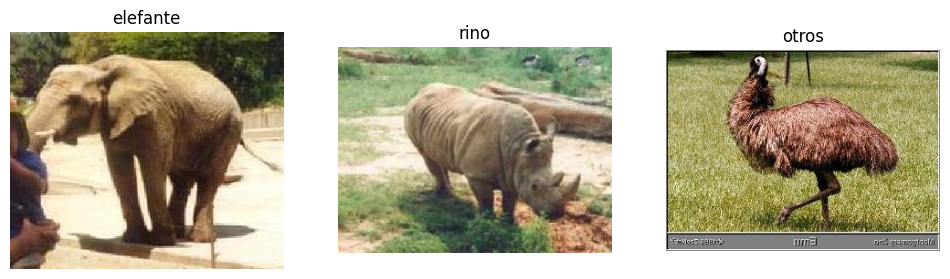

In [1]:
import glob
import skimage.io as io
import skimage.transform as tr
import matplotlib.pyplot as plt
import numpy as np

elefante = glob.glob("../objects/images/elephant/*.jpg") # rutas
rino = glob.glob("../objects/images/rhino/*.jpg")
emu = glob.glob("../objects/images/emu/*.jpg")
flamingo = glob.glob("../objects/images/flamingo/*.jpg")
otros = [*emu, *flamingo]

elefante = [io.imread(i) for i in elefante] #imageneoos
rino = [io.imread(i) for i in rino]
otros = [io.imread(i) for i in otros]


plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(elefante[0])
plt.title("elefante")
plt.axis("off")

plt.subplot(132)
plt.imshow(rino[0])
plt.title("rino")
plt.axis("off")

plt.subplot(133)
plt.imshow(otros[0])
plt.title("otros")
plt.axis("off")

plt.show()

In [2]:
# primero cargaremos las imagenes, las etiquetas y eventualmente las máscaras
# como queremos diferenciar entre elefantes y rinocerontes, no nos vale la pena esforzarnos
# en distinguir si es un emu o un flamenco, entonces todo lo que no nos interese sera 'otros'

# en una primera instancia no considereremos las máscaras
# de esta forma X serán todas las imágenes e Y sera la etiqueta asociada

In [3]:
# ahora armamos X e Y

X = [*elefante, *rino, *otros]
Y =  [*['elefante']*len(elefante), *['rino']*len(rino), *['otros']*len(otros)]

In [4]:
# como hay imagenes en blanco y negro y en color, y eso supone diferencias de tamaño, voy a 
# tridimensionalizar las imagenes en blanco y negro. Triplicando la información que contienen.

def Tridimensionaliza(imagen):
    return np.array([[[imagen[i][j],imagen[i][j],imagen[i][j]] for i in range(np.shape(imagen)[0])] for j in range(np.shape(imagen)[1])])

# ademas, pasamos todos los elementos de X a arrays de numpy
X = [np.array(imagen) if len(np.shape(imagen)) == 3  else Tridimensionaliza(imagen) for imagen in X ] 

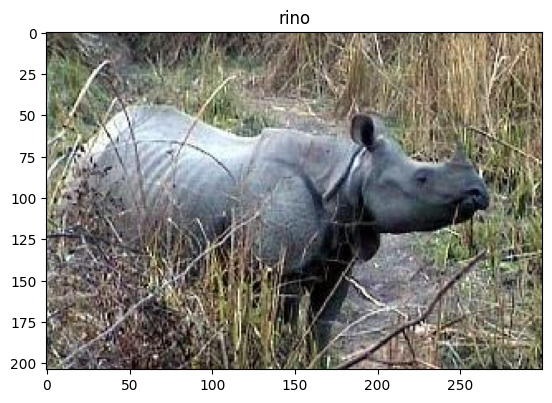

In [5]:
# (como simple demostracion de que lo anterior es correcto..
from random import randint as r

indice = r(0,len(X))

plt.imshow(X[indice])
plt.title(Y[indice])
plt.show()
# ...si al ejecutar, el titulo se corresponde con la imagen es que X e Y estan construidos segun nuestro deseo)

In [5]:
from math import ceil as techo
from random import shuffle as s

# Como cada imagen mide distinto las hacemos todas iguales. Además, las aplanamos

X = [np.array(tr.resize(i,(300,200))).flatten() for i in X]

# Para que nuestras conclusiones sean rigurosas, debemos O usar el error de validación O usar
# una partición de los datos en Entrenamiento y Test. Prodemos con la opción de test


# primero tendremos que desordenarlas, porque si le pasamos solo el final, tendra
# que clasificar exclusivamente 'otros' lo cual no nos interesa

temp = list(zip(X, Y))
s(temp)
X, Y = zip(*temp)


X_entrenamiento = X[:techo(len(X)*.8) ]
X_test =          X[ techo(len(X)*.8):]
Y_entrenamiento = Y[:techo(len(X)*.8) ]
Y_test =          Y[ techo(len(X)*.8):]

# Momento de entrenar

Como en el enunciado de la práctica no se entra en detalle de que algoritmo usar... lo científico por nuestra parte es probar los que nos _tengan sentido_ y ver cual da mejor resultado. Como primer intento, probaremos con KNN...

# Primer intento, sin mascaras con KNN

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# que k usamos? vamos a ver cuantos datos tenemos
#
# $ print(f'hay {len(elefante)} elefantes y {len(rino)} rinocerontes')
# -> hay 64 elefantes y 59 rinocerontes
#
# usaremos un K de entorno a 50, por tanto (prepiero que descuide algunos 
# de su misma clase que que considere algunos de otras clases)

knn=KNeighborsClassifier(n_neighbors=50)
knn.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = knn.predict(X_test)
print(classification_report(Y_predicho,Y_test))

              precision    recall  f1-score   support

    elefante       0.13      0.50      0.21         4
       otros       0.95      0.45      0.62        44
        rino       0.00      0.00      0.00         0

    accuracy                           0.46        48
   macro avg       0.36      0.32      0.28        48
weighted avg       0.88      0.46      0.58        48



/Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/pvc/entornoPvc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/pvc/entornoPvc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/pvc/entornoPvc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set t

In [ ]:
# Malos resultados, pero curiosamente donde mejores resultados
# hubo fue en 'otros'. Vamos a probar a repetir todo pero sin 'otros'

# Segundo intento, sin mascaras con KNN y sin _otros_

In [7]:
X = [*elefante, *rino]
Y =  [*['elefante']*len(elefante), *['rino']*len(rino)]

temp = list(zip(X, Y))
s(temp)
X, Y = zip(*temp)


X = [np.array(imagen) if len(np.shape(imagen)) == 3  else Tridimensionaliza(imagen) for imagen in X ] 

X = [np.array(tr.resize(i,(300,200))).flatten() for i in X]

X_entrenamiento = X[:techo(len(X)*.8) ]
X_test =          X[ techo(len(X)*.8):]
Y_entrenamiento = Y[:techo(len(X)*.8) ]
Y_test =          Y[ techo(len(X)*.8):]

knn=KNeighborsClassifier(n_neighbors=50)
knn.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = knn.predict(X_test)
print(classification_report(Y_predicho,Y_test))

              precision    recall  f1-score   support

    elefante       0.57      0.29      0.38        14
        rino       0.41      0.70      0.52        10

    accuracy                           0.46        24
   macro avg       0.49      0.49      0.45        24
weighted avg       0.50      0.46      0.44        24



Observamos una mejora en los resultados, pero porque ahora la tarea es mucho más sencilla. Un modelo que no sepa nada acertaria en la mitad de las ocasiones.